# Deep Learning

In [1]:
# Boilerplate to chdir to project root and add projects sources to python path
import os
import sys
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    sys.path.append(os.path.abspath('.'))

In [2]:
import biosignals.prepare as bp
import biosignals.evaluation as be
import biosignals.deep_models as bdeep
import biosignals.models as bm
from biosignals.split import Role
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Activation
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

In [3]:
# Only need to run this once.
# bp.prepare_rand()

In [4]:
prepared = bp.read_prepared("rand")
print(prepared)

{<Role.TRAIN: 0>: [ParquetFrameLoader(path='prepared/rand\\train_0.parquet')], <Role.VALIDATE: 1>: [ParquetFrameLoader(path='prepared/rand\\validate_0.parquet')], <Role.TEST: 2>: [ParquetFrameLoader(path='prepared/rand\\test_0.parquet')]}


In [5]:
data = prepared[Role.TRAIN][0].load()
data_val = prepared[Role.VALIDATE][0].load()

Training model <class 'sklearn.ensemble._forest.RandomForestClassifier'> {} Strategy.COMBINED


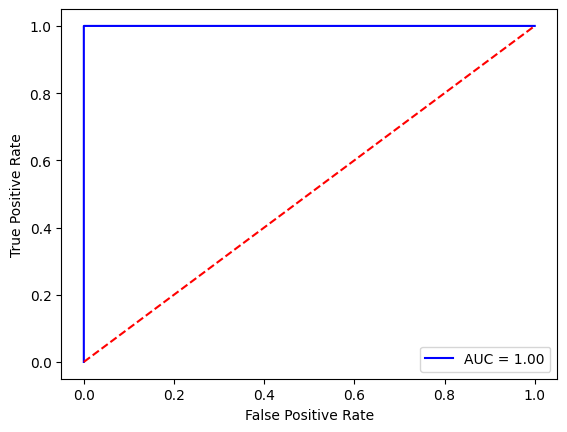

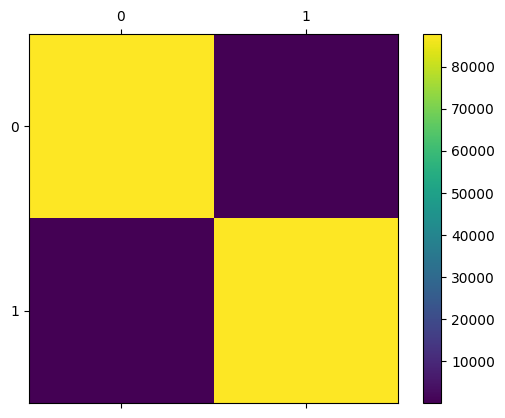

[[87872     2]
 [    1 87873]]
(0.9999829301692169, 0.9999829301044678, 0.9999829301044671, None)


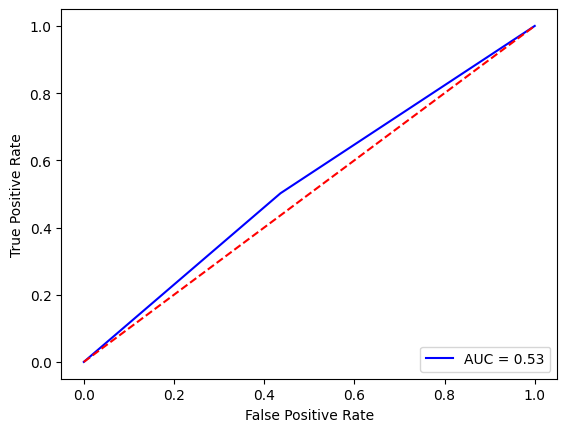

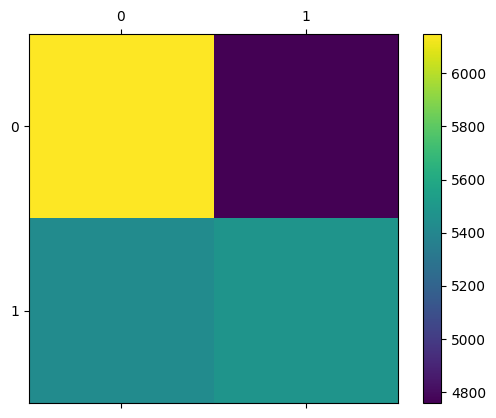

[[6150 4758]
 [5432 5476]]
(0.5330377608107734, 0.5329116244957829, 0.5324653692562843, None)
Results(tn=6150, fp=4758, fn=5432, tp=5476)
accuracy 0.5329116244957829
Training model <class 'sklearn.ensemble._forest.RandomForestClassifier'> {} Strategy.MULTI


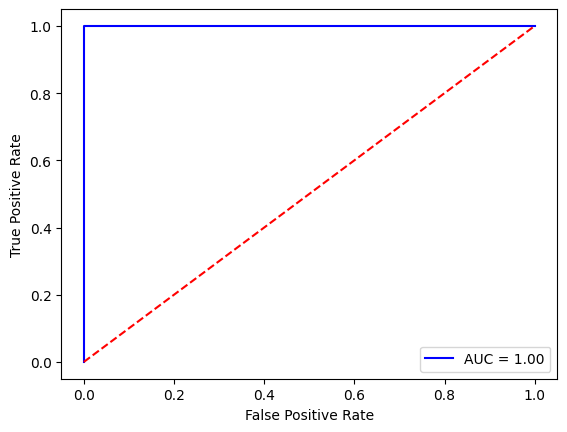

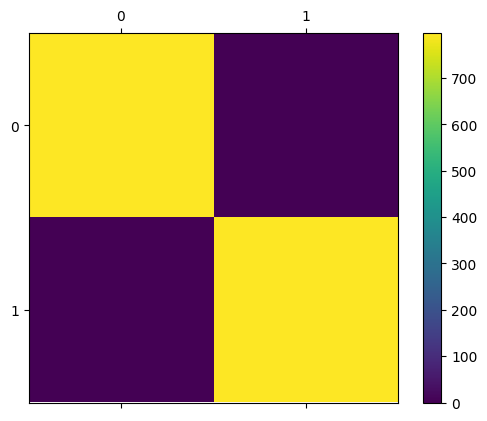

[[797   0]
 [  0 797]]
(1.0, 1.0, 1.0, None)


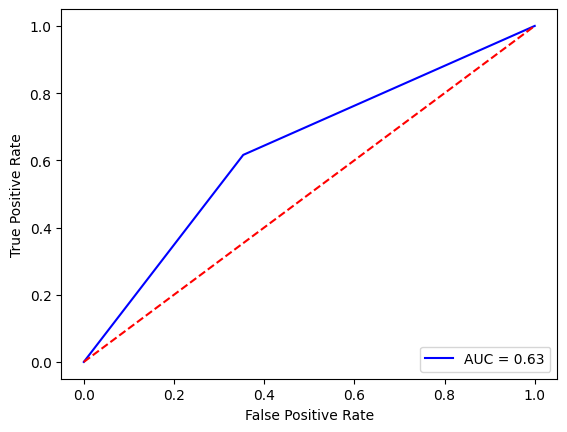

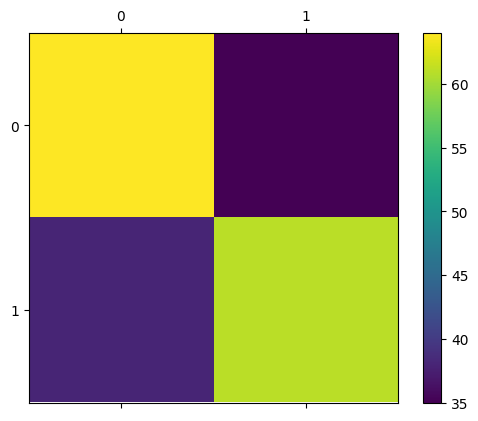

[[64 35]
 [38 61]]
(0.6314338235294117, 0.6313131313131313, 0.6312284730195177, None)
Results(tn=64, fp=35, fn=38, tp=61)
accuracy 0.6313131313131313


In [6]:
# Eric's Random Forest
bm.test_models()

In [7]:
from biosignals.models import *
# Hacky way to obtain the clustered data by abusing Eric's work...
data = bp.read_clusters()
model = bm.SkModel(RandomForestClassifier, {}, Strategy.MULTI)
lds = bp.read_prepared('rand')
data = model._load_all(lds[bs.Role.TRAIN], RandomState(42))
data_val = model._load_all(lds[bs.Role.VALIDATE], RandomState(42))
data_test = model._load_all(lds[bs.Role.TEST], RandomState(42))

Reading clusters


In [8]:
print(data[0].shape, data[1].shape, data_val[0].shape, data_val[1].shape, data_test[0].shape, data_test[1].shape)

(1594, 224) (1594,) (196, 224) (196,) (198, 224) (198,)


In [9]:
train_data = tf.convert_to_tensor(data[0], dtype=tf.float64)
train_labels = tf.convert_to_tensor(data[1], dtype=tf.int32)
print(train_labels.shape, train_data.shape)

val_data = tf.convert_to_tensor(data_val[0], dtype=tf.float64)
val_labels = tf.convert_to_tensor(data_val[1], dtype=tf.int32)

test_data = tf.convert_to_tensor(data_test[0], dtype=tf.float64)
test_labels = tf.convert_to_tensor(data_test[1], dtype=tf.int32)

(1594,) (1594, 224)


In [10]:
#standard scalar
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

#PCA
n_components = 64
pca = PCA(n_components=n_components)
pca.fit(train_data)
train_data_pca = pca.transform(train_data)
val_data_pca = pca.transform(val_data)
test_data_pca = pca.transform(test_data)


# Expand dimensions
train_data_pca = tf.expand_dims(train_data_pca, axis=1)
val_data_pca = tf.expand_dims(val_data_pca, axis=1)
test_data_pca = tf.expand_dims(test_data_pca, axis=1)

train_data_nopca = tf.expand_dims(train_data, axis=1)
val_data_nopca = tf.expand_dims(val_data, axis=1)
test_data_nopca = tf.expand_dims(test_data, axis=1)

print(train_data_pca.shape, val_data_pca.shape, test_data_pca.shape)
print(train_data_nopca.shape, val_data_nopca.shape, test_data_nopca.shape)

(1594, 1, 64) (196, 1, 64) (198, 1, 64)
(1594, 1, 224) (196, 1, 224) (198, 1, 224)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 512)            1133568   
                                                                 
 activation (Activation)     (None, 1, 512)            0         
                                                                 
 gru_1 (GRU)                 (None, 256)               591360    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,725,185
Trainable params: 1,725,185
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 3s 16ms/step - loss: 0.7006 - accuracy: 0.5201
Epoch 2/30
25/25 [==============================] - 0s 15ms/step - loss: 0

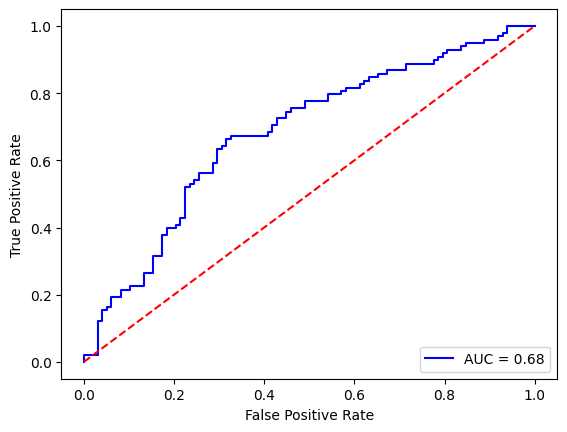

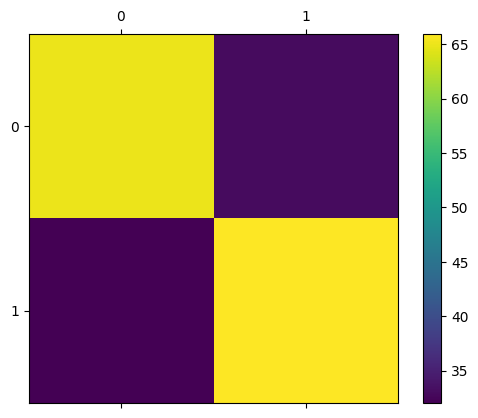

[[65 33]
 [32 66]]
(0.6683848797250859, 0.6683673469387754, 0.6683587140439932, None)


In [11]:
# GRU NO PCA
model_GRU_nopca = bdeep.GRU_Model(train_data_nopca, train_labels, num_epochs=30, batch_size=64)
be.evaluate_model(model_GRU_nopca.predict(val_data_nopca), val_labels)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 1, 512)            887808    
                                                                 
 activation_1 (Activation)   (None, 1, 512)            0         
                                                                 
 gru_3 (GRU)                 (None, 256)               591360    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,479,425
Trainable params: 1,479,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 4s 18ms/step - loss: 0.6964 - accuracy: 0.5238
Epoch 2/30
25/25 [==============================] - 0s 15ms/step - loss:

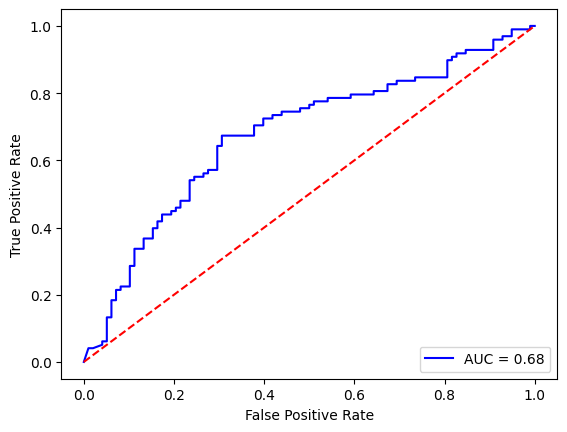

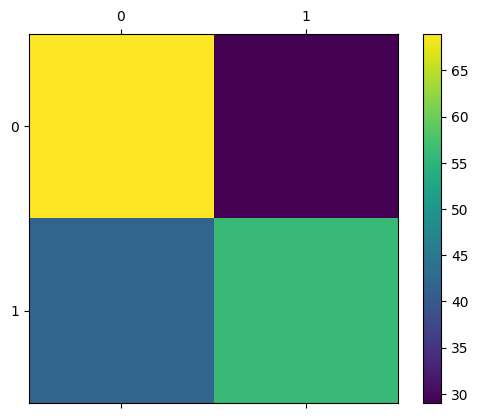

[[69 29]
 [42 56]]
(0.6402225755166931, 0.6377551020408163, 0.636154469631605, None)


In [12]:
# GRU WITH PCA
model_GRU_pca = bdeep.GRU_Model(train_data_pca, train_labels, num_epochs=30, batch_size=64)
be.evaluate_model(model_GRU_pca.predict(val_data_pca), val_labels)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 512)            1509376   
                                                                 
 activation_2 (Activation)   (None, 1, 512)            0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,297,089
Trainable params: 2,297,089
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 3s 24ms/step - loss: 0.6958 - accuracy: 0.4912
Epoch 2/30
25/25 [==============================] - 1s 21ms/step - loss:

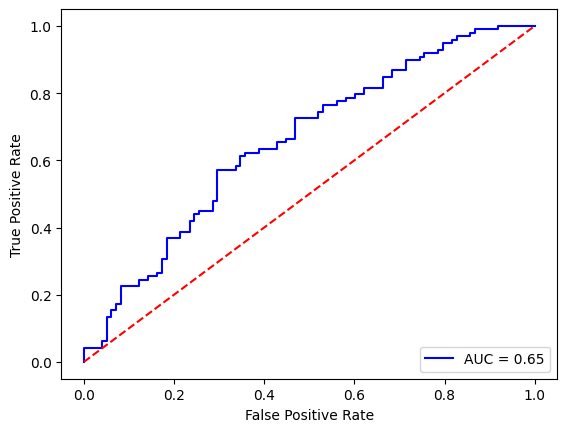

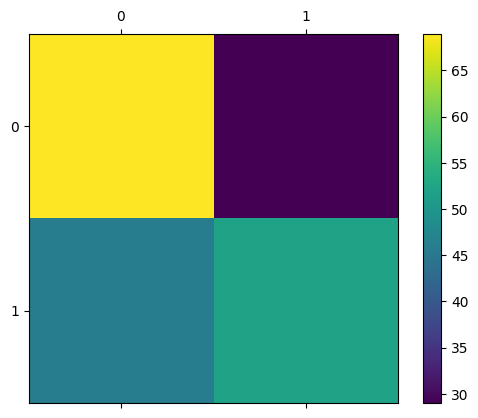

[[69 29]
 [46 52]]
(0.6209876543209876, 0.6173469387755102, 0.6144464552679205, None)


In [13]:
# LSTM NO PCA
model_LSTM_nopca = bdeep.LSTM_Model(train_data_nopca, train_labels, num_epochs=30, batch_size=64)
be.evaluate_model(model_LSTM_nopca.predict(val_data_nopca), val_labels)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 512)            1181696   
                                                                 
 activation_3 (Activation)   (None, 1, 512)            0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,969,409
Trainable params: 1,969,409
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 3s 18ms/step - loss: 0.6941 - accuracy: 0.5107
Epoch 2/30
25/25 [==============================] - 0s 18ms/step - loss:

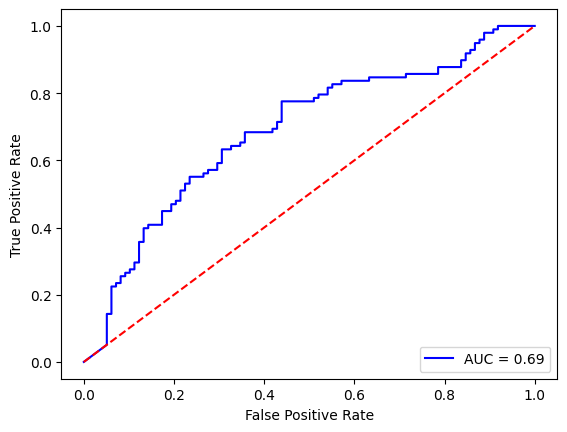

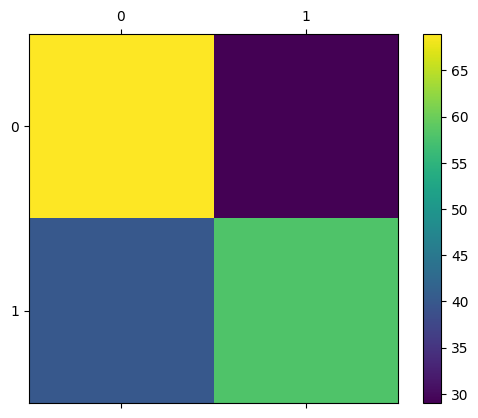

[[69 29]
 [40 58]]
(0.6498470948012232, 0.6479591836734694, 0.6468468468468469, None)


In [14]:
# LSTM WITH PCA
model_LSTM_pca = bdeep.LSTM_Model(train_data_pca, train_labels, num_epochs=30, batch_size=64)
be.evaluate_model(model_LSTM_pca.predict(val_data_pca), val_labels)

GRU - no PCA
7/7 [==============================] - 0s 4ms/step


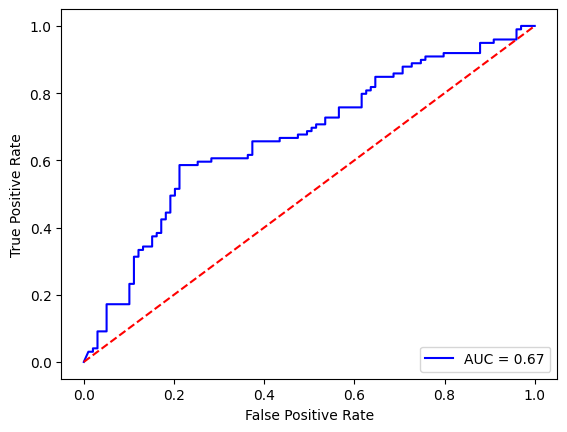

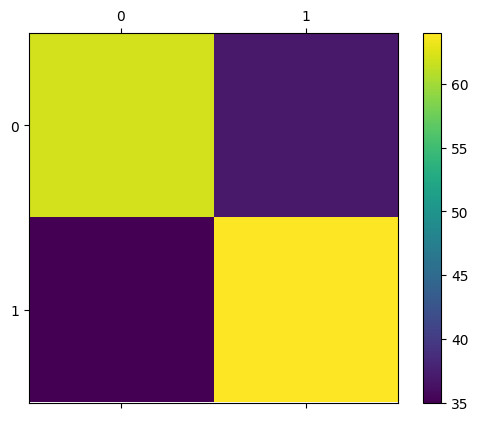

[[62 37]
 [35 64]]
(0.6364193120342962, 0.6363636363636365, 0.636326530612245, None)
GRU - with PCA
7/7 [==============================] - 0s 4ms/step


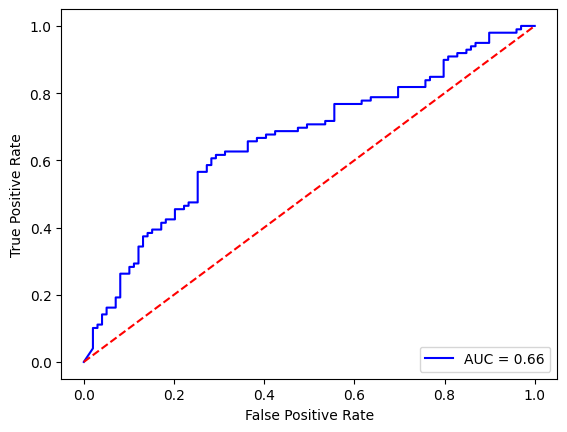

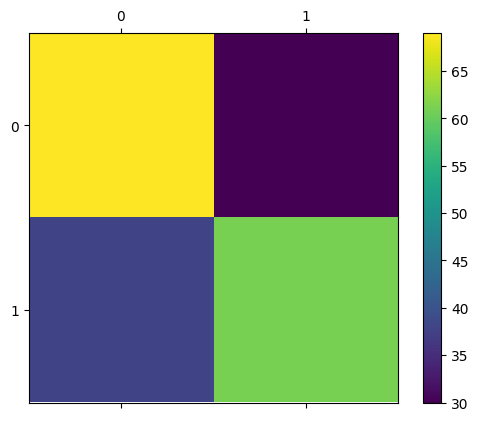

[[69 30]
 [38 61]]
(0.6575947417068913, 0.6565656565656566, 0.6560040878896269, None)
LSTM - no PCA
7/7 [==============================] - 0s 5ms/step


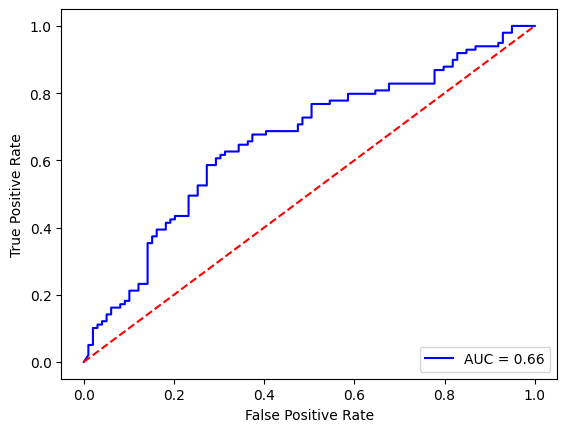

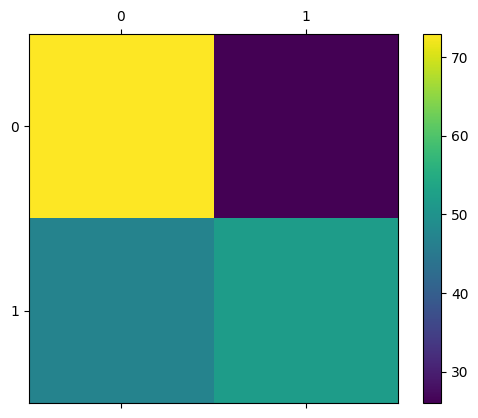

[[73 26]
 [47 52]]
(0.6375, 0.6313131313131313, 0.6271186440677965, None)
LSTM - with PCA
7/7 [==============================] - 0s 4ms/step


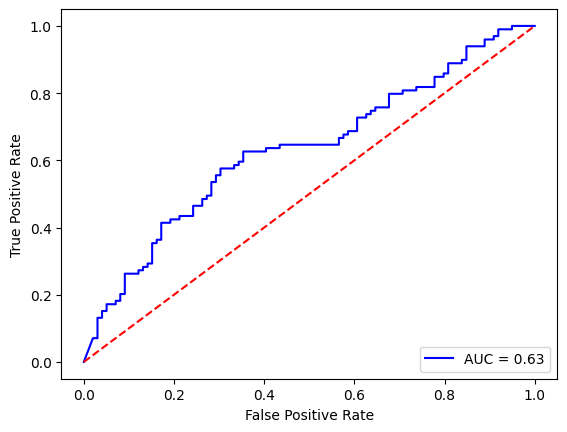

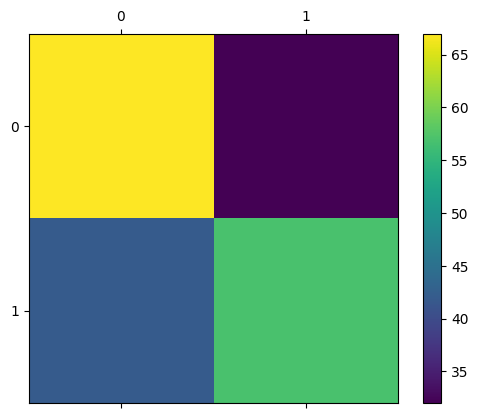

[[67 32]
 [42 57]]
(0.627564168642408, 0.6262626262626263, 0.6253068739770868, None)


In [15]:
# Test evaluation
print("GRU - no PCA")
be.evaluate_model(model_GRU_nopca.predict(test_data_nopca), test_labels)
print("GRU - with PCA")
be.evaluate_model(model_GRU_pca.predict(test_data_pca), test_labels)

print("LSTM - no PCA")
be.evaluate_model(model_LSTM_nopca.predict(test_data_nopca), test_labels)
print("LSTM - with PCA")
be.evaluate_model(model_LSTM_pca.predict(test_data_pca), test_labels)

GRU - no PCA
50/50 [==============================] - 0s 4ms/step


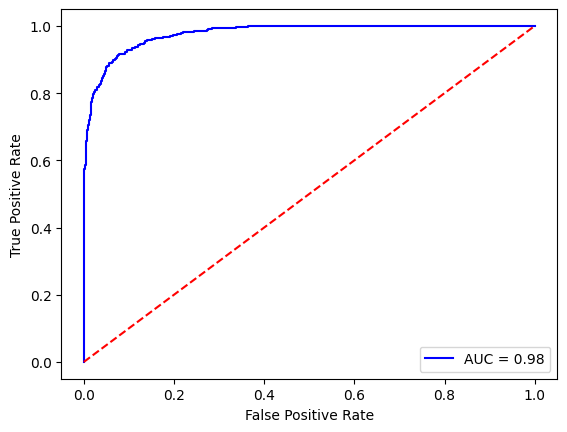

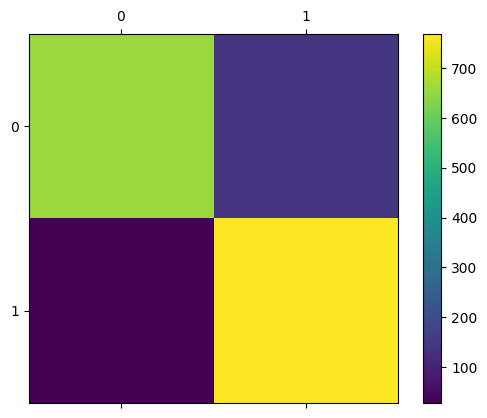

[[659 138]
 [ 28 769]]
(0.903546570503716, 0.8958594730238394, 0.8953611606747403, None)
GRU - PCA
50/50 [==============================] - 0s 4ms/step


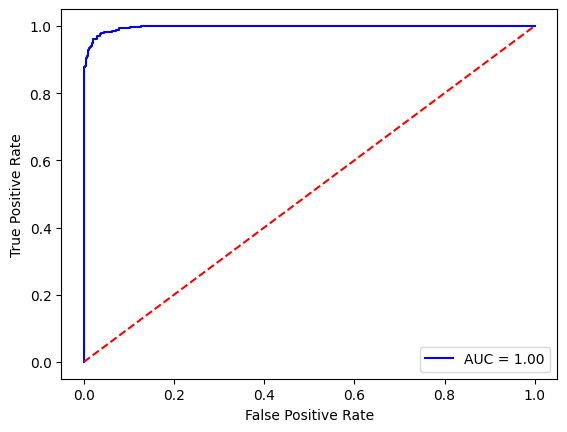

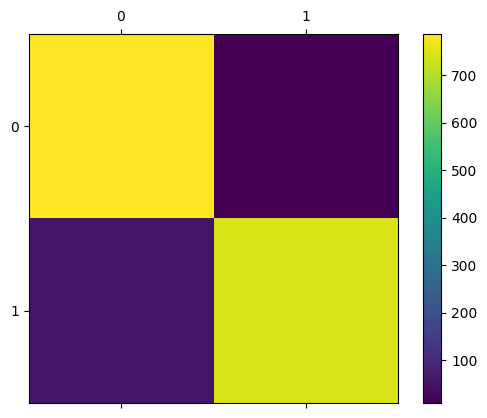

[[788   9]
 [ 54 743]]
(0.9619494491332693, 0.9604767879548306, 0.960445263550536, None)
LSTM - no PCA
50/50 [==============================] - 0s 5ms/step


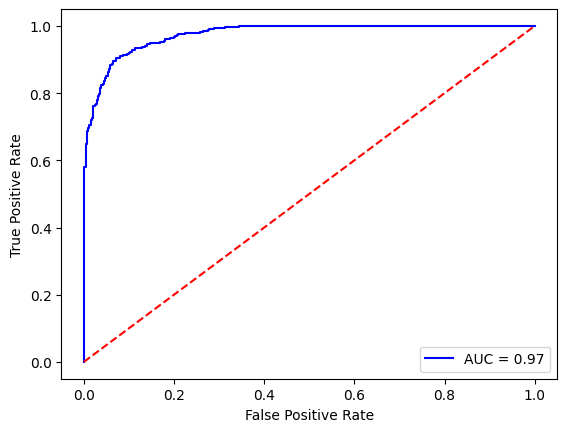

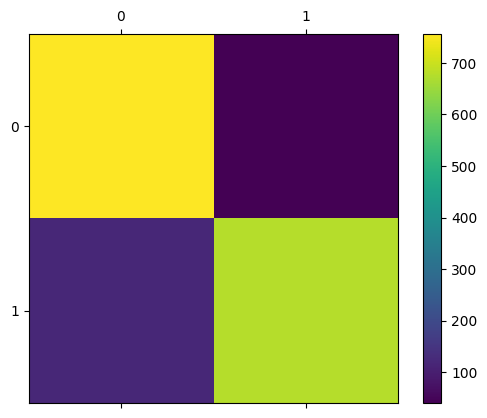

[[757  40]
 [119 678]]
(0.9042224723674337, 0.9002509410288582, 0.9000053262947335, None)
LSTM - PCA
50/50 [==============================] - 0s 4ms/step


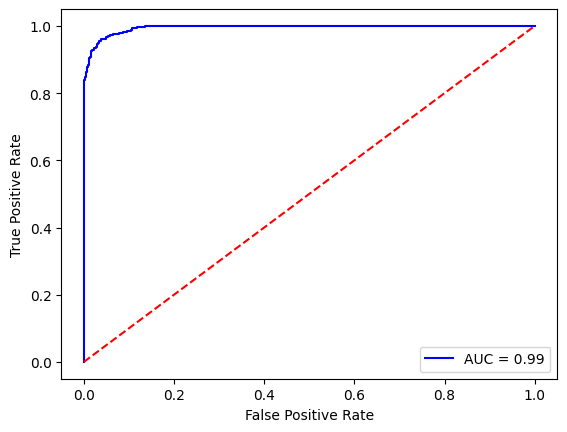

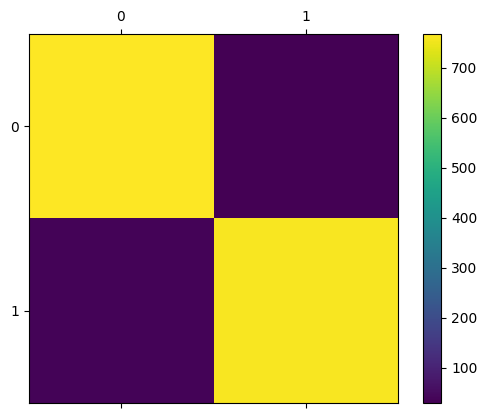

[[768  29]
 [ 35 762]]
(0.9598754984862392, 0.9598494353826851, 0.9598488664987406, None)


In [16]:
# Training evaluation (to see if we overfit)
print("GRU - no PCA")
be.evaluate_model(model_GRU_nopca.predict(train_data_nopca), train_labels)
print("GRU - PCA")
be.evaluate_model(model_GRU_pca.predict(train_data_pca), train_labels)
print("LSTM - no PCA")
be.evaluate_model(model_LSTM_nopca.predict(train_data_nopca), train_labels)
print("LSTM - PCA")
be.evaluate_model(model_LSTM_pca.predict(train_data_pca), train_labels)